# Evolution of a margin

This notebook reproduces the [margin example](https://fastscape-lem.github.io/fastscapelib-fortran/#_margin_f90) provided in the fastscapelib-fortran library. It illustrates continental transport/deposition and sediment transport/deposition in submarine environments.

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import, customize and inspect the model

In [3]:
from fastscape.models import marine_model

We use here a slightly simpler version of ``marine_model``:

In [4]:
from fastscape.processes import LinearDiffusion, StreamPowerChannelTD


model = marine_model.update_processes({
    'spl': StreamPowerChannelTD,
    'diffusion': LinearDiffusion
}).drop_processes(
    'strati'
)

In [5]:
model

<xsimlab.Model (21 processes, 25 inputs)>
grid
    length               [in] ('shape_yx',) total grid length in (y...
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
fs_context
boundary
    status               [in] () or ('border',) node status at borders
uplift
    rate_left            [in] uplift rate of the left block
    rate_right           [in] uplift rate of the right block
    x_position           [in] position of the clip plane along the ...
tectonics
init_topography
    x_right              [in] location of the scarp's right limit o...
    elevation_left       [in] elevation on the left side of the scarp
    elevation_right      [in] elevation on the right side of the scarp
    x_left               [in] location of the scarp's left limit on...
surf2erode
init_bedrock
active_layer
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
flow
    slope_exp            [in] MFD partioner slope exponent
drainage
spl
    area_exp     

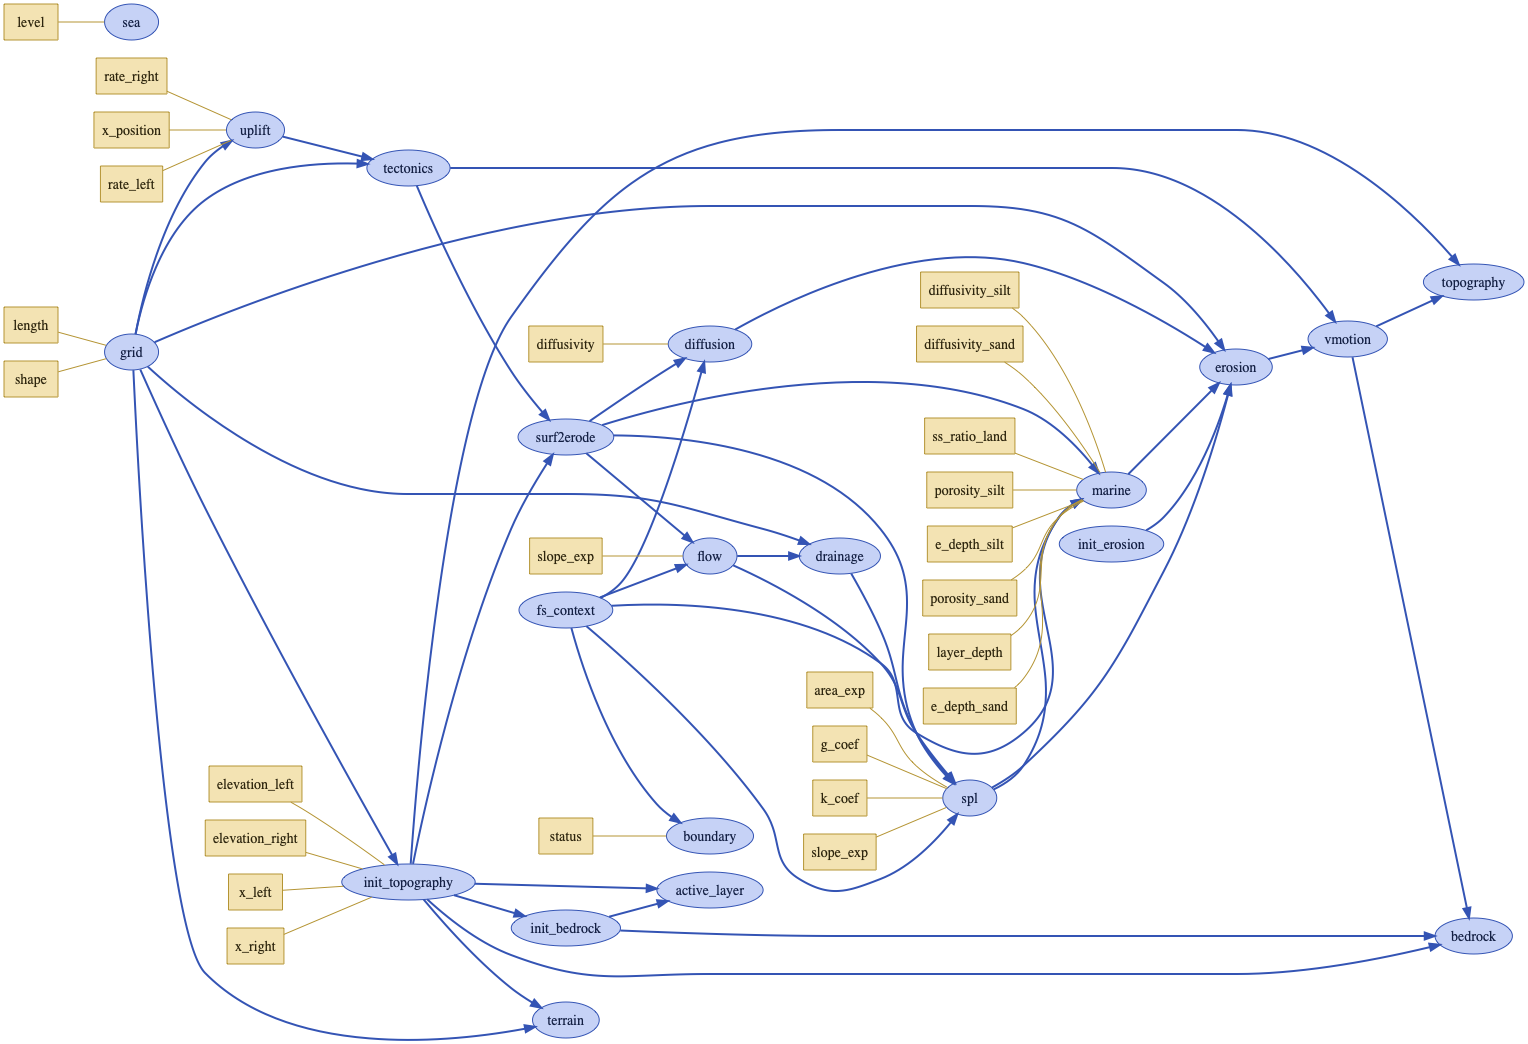

In [6]:
model.visualize(show_inputs=True)

## Model setup

In [7]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.arange(0, 1e6 + 1e3, 1e3),
        'out': np.arange(0, 1e6 + 5e4, 5e4),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [101, 151],
        'grid__length': [1e5, 1.5e5],
        'boundary__status': ['fixed_value', 'core', 'looped', 'looped'],
        'init_topography': {
            'x_left': 0.75e5,
            'x_right': 0.75e5,
            'elevation_left': -1000.,
            'elevation_right': 0.
        },
        'uplift': {
            'x_position': 0.75e5,
            'rate_left': 0.,
            'rate_right': 1e-3
        },
        'flow__slope_exp': 1.,
        'spl': {
            'k_coef': 1e-5,
            'g_coef': 1.,
            'area_exp': 0.8,
            'slope_exp': 2.
        },
        'diffusion__diffusivity': 1e-2,
        'marine': {
            'ss_ratio_land': 0.5,
            'porosity_sand': 0.,
            'porosity_silt': 0.,
            'e_depth_sand': 1e3,
            'e_depth_silt': 1e3,
            'diffusivity_sand': 3e2 / 2.,
            'diffusivity_silt': 3e2,
            'layer_depth': 1e2,
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'marine__ss_ratio_sea': 'out',
    }
)

in_ds

<xarray.Dataset>
Dimensions:                           (border: 4, out: 21, shape_yx: 2, time: 1001)
Coordinates:
  * time                              (time) float64 0.0 1e+03 ... 1e+06
  * out                               (out) float64 0.0 5e+04 ... 9.5e+05 1e+06
Dimensions without coordinates: border, shape_yx
Data variables:
    sea__level                        float64 0.0
    grid__shape                       (shape_yx) int64 101 151
    grid__length                      (shape_yx) float64 1e+05 1.5e+05
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    init_topography__x_left           float64 7.5e+04
    init_topography__x_right          float64 7.5e+04
    init_topography__elevation_left   float64 -1e+03
    init_topography__elevation_right  float64 0.0
    uplift__x_position                float64 7.5e+04
    uplift__rate_left                 float64 0.0
    uplift__rate_right                float64 0.001
    flow__slope_exp                   

## Run the model

In [8]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

In [9]:
out_ds

<xarray.Dataset>
Dimensions:                           (border: 4, out: 21, shape_yx: 2, time: 1001, x: 151, y: 101)
Coordinates:
  * border                            (border) <U6 'left' 'right' 'top' 'bottom'
  * out                               (out) float64 0.0 5e+04 ... 9.5e+05 1e+06
  * time                              (time) float64 0.0 1e+03 ... 1e+06
  * x                                 (x) float64 0.0 1e+03 ... 1.49e+05 1.5e+05
  * y                                 (y) float64 0.0 1e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status                  (border) <U11 'fixed_value' ... 'looped'
    diffusion__diffusivity            float64 0.01
    flow__slope_exp                   float64 1.0
    grid__length                      (shape_yx) float64 1e+05 1.5e+05
    grid__shape                       (shape_yx) int64 101 151
    init_topography__elevation_left   float64 -1e+03
    init_topography__elevation_right  float64 0.0
   

## Plot the outputs (topography and stratigraphic horizons)

In [10]:
import hvplot.xarray
import holoviews as hv
from xshade import hillshade


ss_ratio_plot = out_ds.marine__ss_ratio_sea.hvplot.image(
    x='x', y='y', clim=(0, 1),
    width=550, height=350,
    cmap=plt.cm.viridis_r, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.7,
    colorbar=False, hover=False, groupby='out'
)

ysections =  out_ds.topography__elevation.sel(y=[2.5e4, 5e4, 7.5e4])

sections_plot = ysections.hvplot.line(
    by='y', groupby='out', ylim=(-1e3, 1e3),
    width=550, height=200, legend='top_left',
)

hv.Layout((ss_ratio_plot * hillshade_plot) + sections_plot).cols(1)

:Layout
   .DynamicMap.I  :DynamicMap   [out]
      :Overlay
         .Image.I  :Image   [x,y]   (marine__ss_ratio_sea)
         .Image.II :Image   [x,y]   (hillshade)
   .DynamicMap.II :DynamicMap   [out]
      :NdOverlay   [y]
         :Curve   [x]   (topography__elevation)